In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import trim_mean
from numpy import mean, absolute
import random

data = pd.read_csv('../data/weatherAUS.csv')

In [18]:
theme = ['#16A085','#DBFE87','#FFE381','#1C448E','#2D3319','#EDF184','#8E9488','#79CF86',
         '#48B886','#253C54','#BCD984','#214071','#E57A44','#7E8D65','#F2AF63','#A18261',
         '#725151','#D0B371']

mpl.rcParams['figure.dpi']= 400

### 4.1.1 Missing Values Juan

It is not unusual for an object to be missing one or more attribute values. In some cases, the information was not collected; while in other cases, some attributes are inapplicable to the data instances. This section presents examples on the different approaches for handling missing values. 

According to the description of the data (https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original), the missing values are encoded as '?' in the original data. Our first task is to convert the missing values to NaNs. We can then count the number of missing values in each column of the data.

**<font color="red">Code:</font>**

In [ ]:
import numpy as np

data = data.replace('?',np.NaN)

print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))

print('Number of missing values:')
for col in data.columns:
    print('\t%s: %d' % (col,data[col].isna().sum()))

Observe that only the 'Bare Nuclei' column contains missing values. In the following example, the missing values in the 'Bare Nuclei' column are replaced by the median value of that column. The values before and after replacement are shown for a subset of the data points.

**<font color="red">Code:</font>**

In [ ]:
data2 = data['Bare Nuclei']

print('Before replacing missing values:')
print(data2[20:25])
data2 = data2.fillna(data2.median())

print('\nAfter replacing missing values:')
print(data2[20:25])

Instead of replacing the missing values, another common approach is to discard the data points that contain missing values. This can be easily accomplished by applying the dropna() function to the data frame.

**<font color="red">Code:</font>**

In [ ]:
print('Number of rows in original data = %d' % (data.shape[0]))

data2 = data.dropna()
print('Number of rows after discarding missing values = %d' % (data2.shape[0]))

### 4.1.2 Outliers Andrea
Para remover outliers se normaliza el dataset restando a cada valor la media y dividiendo por la desviacion estandar. Luego se escogen aquellos valores normalizados menores que 3 y mayores que -3. 

In [26]:
data = data.select_dtypes(include='float64')
# normalizar
Z = (data-data.mean())/data.std()

print('Numero de registros sin descartar outliers = %d' % (Z.shape[0]))

data_without_outliers = data.loc[((Z > -3).sum(axis=1)==16) & ((Z <= 3).sum(axis=1)==16),:]
print('Numero de registros al descartar outliers = %d' % (data_without_outliers.shape[0]))

Numero de registros sin descartar outliers = 145460
Numero de registros al descartar outliers = 55360


Las gráficas de caja generadas durante el análisis exploratorio previo a la exclusión de valores atípicos se vuelven a graficar, esta vez retirando los outliers. Se puede evidenciar, en el caso de las temperaturas, que los valores atípicos han sido completamente eliminados. En cuanto a las variables relacionadas con la velocidad del viento, se observa una disminución de estos valores atípicos, aunque todavía persiste una cantidad considerable en las mediciones de lluvia y evaporación. Respecto a las variables de presión y humedad, también se ha reducido la presencia de valores atípicos. Sin embargo, se debe aclarar que no fue necesario eliminar valores atípicos en las mediciones de la 'Sunshine' y la cobertura de nubes.

Text(0, 0.5, 'velocidad km / hr')

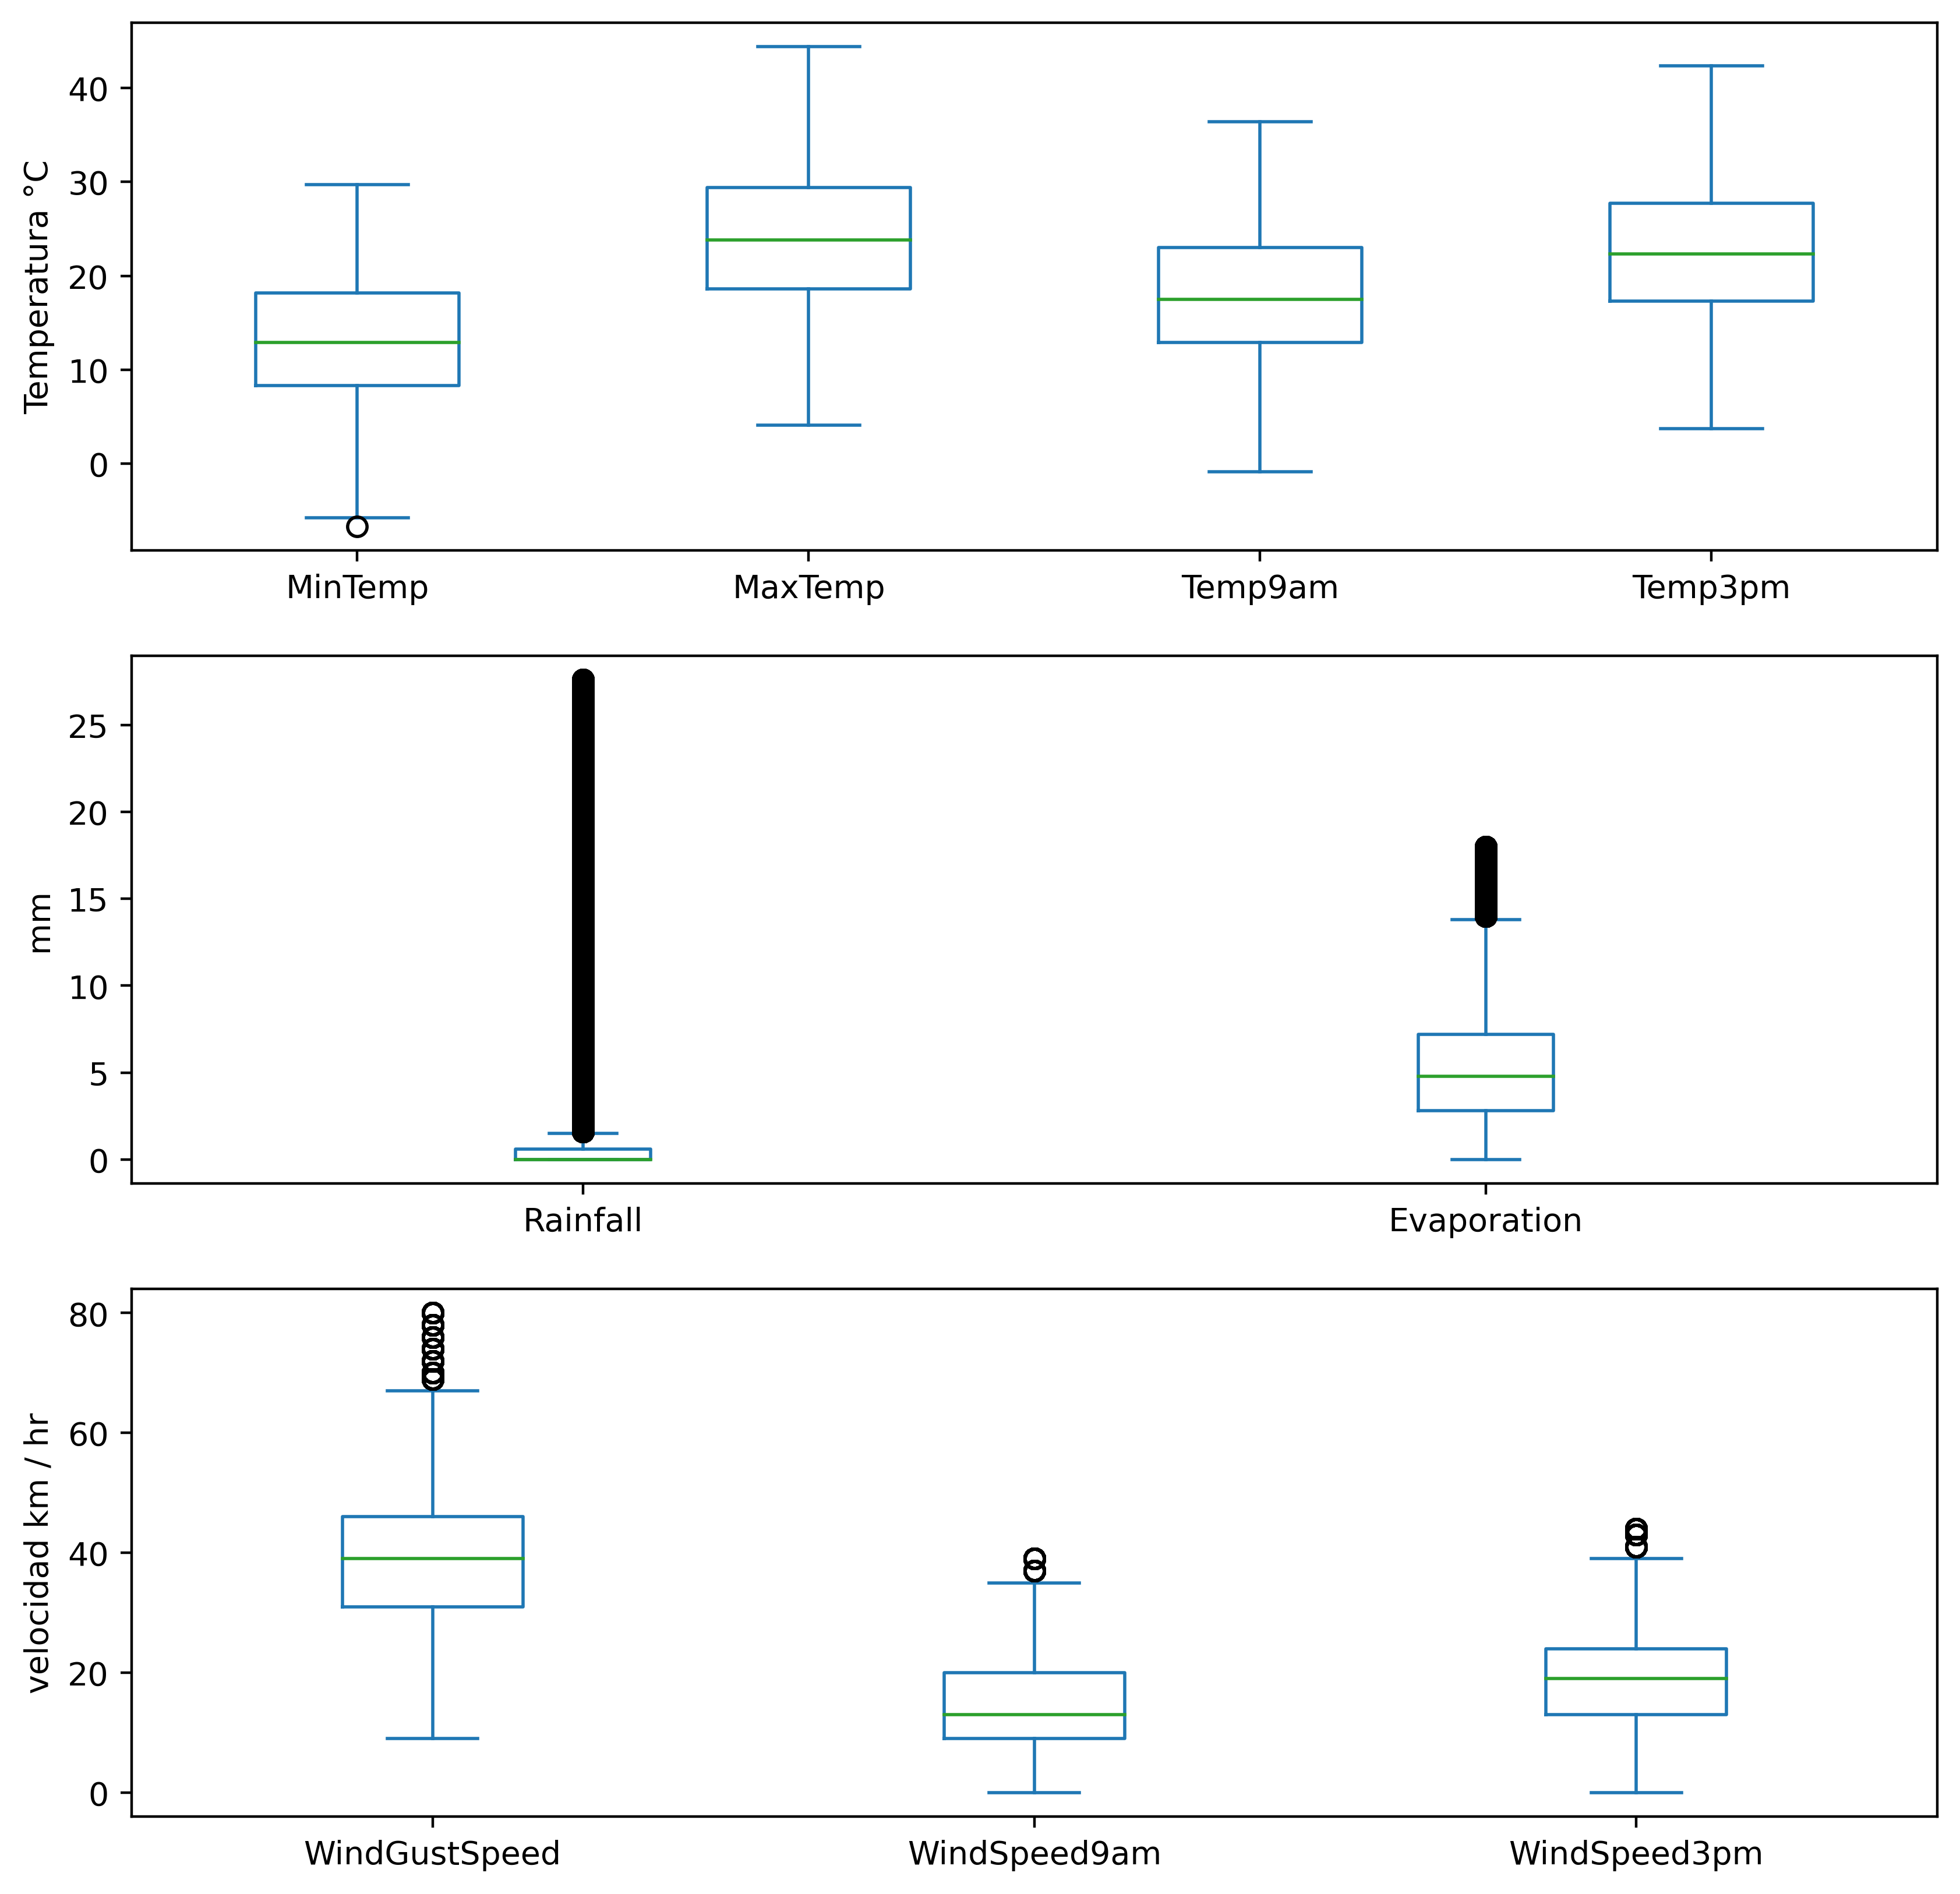

In [23]:
fig, axes = plt.subplots(3, 1)
fig.set_size_inches((10,10))
data_without_outliers[['MinTemp','MaxTemp','Temp9am','Temp3pm']].plot.box(ax=axes[0]);
axes[0].set_ylabel('Temperatura °C')
data_without_outliers[['Rainfall','Evaporation']].plot.box(ax=axes[1]);
axes[1].set_ylabel('mm')
data_without_outliers[['WindGustSpeed','WindSpeed9am','WindSpeed3pm']].plot.box(ax=axes[2]);
axes[2].set_ylabel('velocidad km / hr')

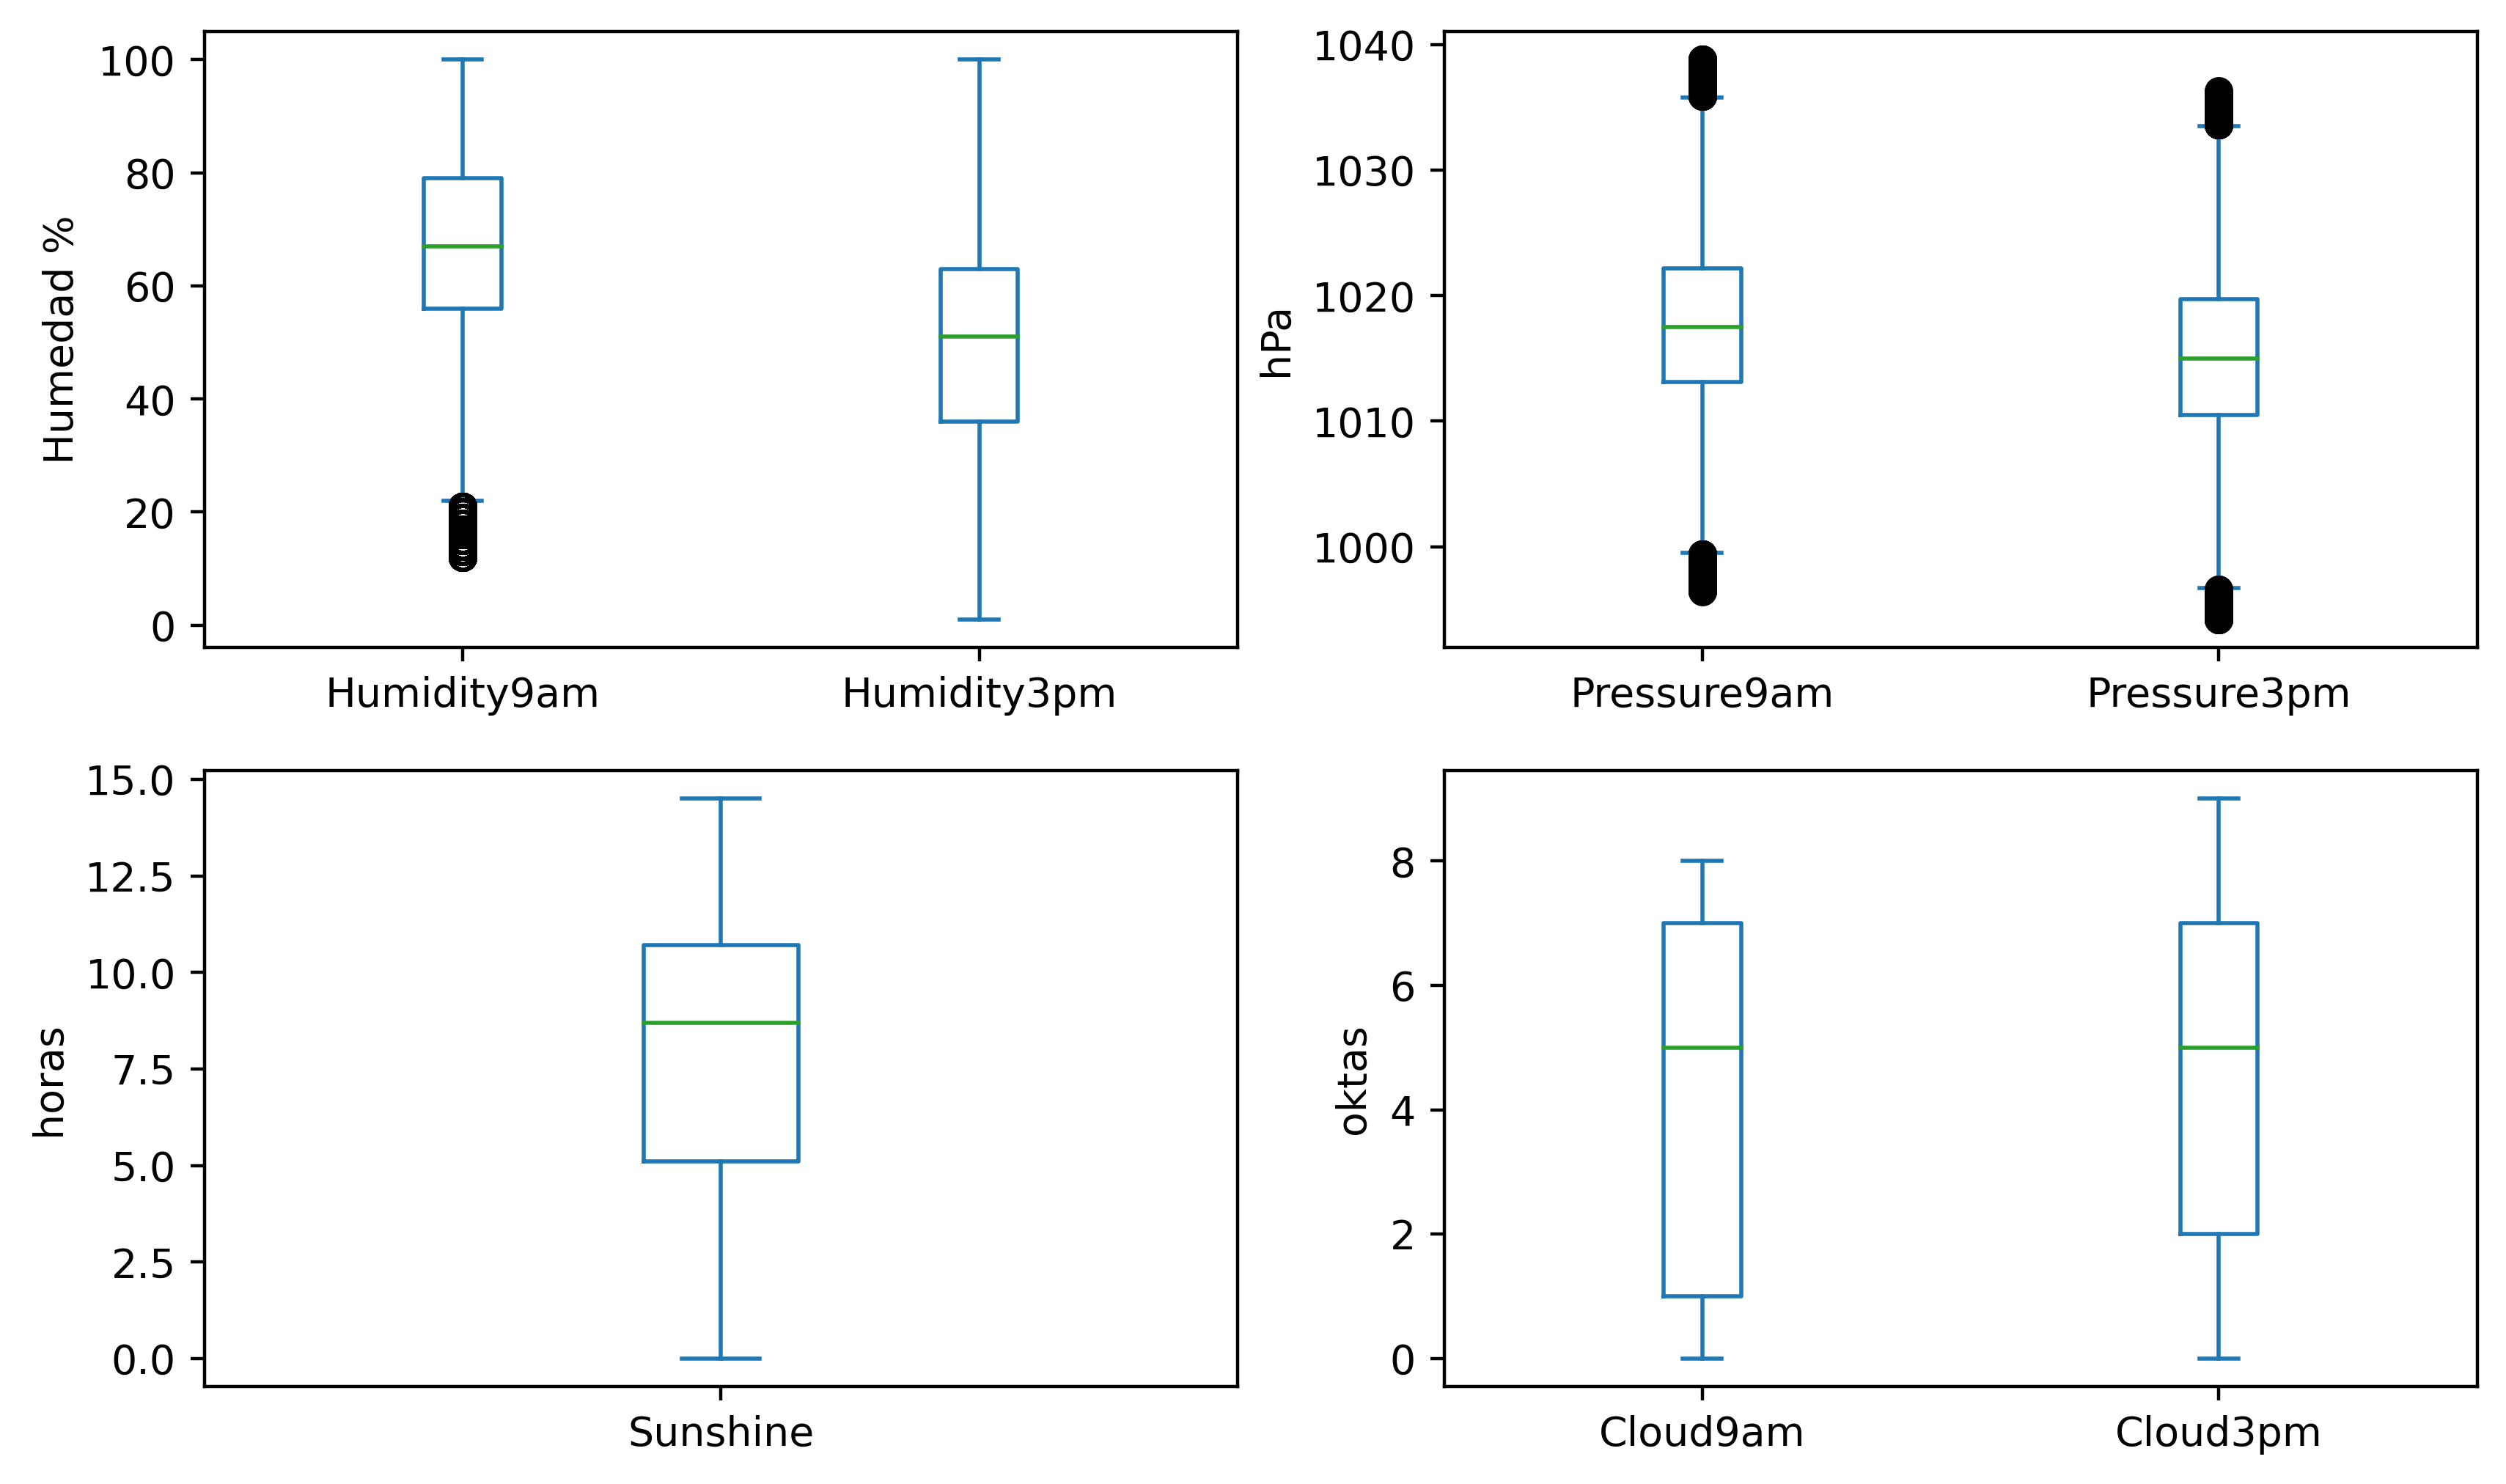

In [25]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches((10,6))
data_without_outliers[['Humidity9am','Humidity3pm']].plot.box(ax=axes[0][0]);
axes[0][0].set_ylabel(r'Humedad %');
data_without_outliers[['Pressure9am','Pressure3pm']].plot.box(ax=axes[0][1]);
axes[0][1].set_ylabel('hPa');
data_without_outliers[['Sunshine']].plot.box(ax=axes[1][0]);
axes[1][0].set_ylabel('horas');
data_without_outliers[['Cloud9am','Cloud3pm']].plot.box(ax=axes[1][1]);
axes[1][1].set_ylabel('oktas');

### 4.1.3 Duplicate Data Juan

Some datasets, especially those obtained by merging multiple data sources, may contain duplicates or near duplicate instances. The term deduplication is often used to refer to the process of dealing with duplicate data issues. 

**<font color="red">Code:</font>**

In the following example, we first check for duplicate instances in the breast cancer dataset.

In [ ]:
dups = data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
data.loc[[11,28]]

The duplicated() function will return a Boolean array that indicates whether each row is a duplicate of a previous row in the table. The results suggest there are 236 duplicate rows in the breast cancer dataset. For example, the instance with row index 11 has identical attribute values as the instance with row index 28. Although such duplicate rows may correspond to samples for different individuals, in this hypothetical example, we assume that the duplicates are samples taken from the same individual and illustrate below how to remove the duplicated rows.

**<font color="red">Code:</font>**

In [ ]:
print('Number of rows before discarding duplicates = %d' % (data.shape[0]))
data2 = data.drop_duplicates()
print('Number of rows after discarding duplicates = %d' % (data2.shape[0]))

## 4.2 Aggregation Andrea

Data aggregation is a preprocessing task where the values of two or more objects are combined into a single object. The motivation for aggregation includes (1) reducing the size of data to be processed, (2) changing the granularity of analysis (from fine-scale to coarser-scale), and (3) improving the stability of the data.

In the example below, we will use the daily precipitation time series data for a weather station located at Detroit Metro Airport. The raw data was obtained from the Climate Data Online website (https://www.ncdc.noaa.gov/cdo-web/). The daily precipitation time series will be compared against its monthly values.

**<font color="red">Code:</font>**

The code below will load the precipitation time series data and draw a line plot of its daily time series.

In [ ]:
daily = pd.read_csv('DTW_prec.csv', header='infer')
daily.index = pd.to_datetime(daily['DATE'])
daily = daily['PRCP']
ax = daily.plot(kind='line',figsize=(15,3))
ax.set_title('Daily Precipitation (variance = %.4f)' % (daily.var()))

Observe that the daily time series appear to be quite chaotic and varies significantly from one time step to another. The time series can be grouped and aggregated by month to obtain the total monthly precipitation values. The resulting time series appears to vary more smoothly compared to the daily time series.

**<font color="red">Code:</font>**

In [ ]:
monthly = daily.groupby(pd.Grouper(freq='M')).sum()
ax = monthly.plot(kind='line',figsize=(15,3))
ax.set_title('Monthly Precipitation (variance = %.4f)' % (monthly.var()))

In the example below, the daily precipitation time series are grouped and aggregated by year to obtain the annual precipitation values. 

**<font color="red">Code:</font>**

In [ ]:
annual = daily.groupby(pd.Grouper(freq='Y')).sum()
ax = annual.plot(kind='line',figsize=(15,3))
ax.set_title('Annual Precipitation (variance = %.4f)' % (annual.var()))

## 4.3 Sampling Juan

Sampling is an approach commonly used to facilitate (1) data reduction for exploratory data analysis and scaling up algorithms to big data applications and (2) quantifying uncertainties due to varying data distributions. There are various methods available for data sampling, such as sampling without replacement, where each selected instance is removed from the dataset, and sampling with replacement, where each selected instance is not removed, thus allowing it to be selected more than once in the sample.

In the example below, we will apply sampling with replacement and without replacement to the breast cancer dataset obtained from the UCI machine learning repository.

**<font color="red">Code:</font>**

We initially display the first five records of the table.

In [ ]:
data.head()

In the following code, a sample of size 3 is randomly selected (without replacement) from the original data.

**<font color="red">Code:</font>**

In [ ]:
sample = data.sample(n=3)
sample

In the next example, we randomly select 1% of the data (without replacement) and display the selected samples. The random_state argument of the function specifies the seed value of the random number generator.

**<font color="red">Code:</font>**

In [ ]:
sample = data.sample(frac=0.01, random_state=1)
sample

Finally, we perform a sampling with replacement to create a sample whose size is equal to 1% of the entire data. You should be able to observe duplicate instances in the sample by increasing the sample size.

**<font color="red">Code:</font>**

In [ ]:
sample = data.sample(frac=0.01, replace=True, random_state=1)
sample

## 4.4 Binarización Juan

Prueba

## 4.4 Discretization Andrea

Discretization is a data preprocessing step that is often used to transform a continuous-valued attribute to a categorical attribute. The example below illustrates two simple but widely-used unsupervised discretization methods (equal width and equal depth) applied to the 'Clump Thickness' attribute of the breast cancer dataset.

First, we plot a histogram that shows the distribution of the attribute values. The value_counts() function can also be applied to count the frequency of each attribute value.

**<font color="red">Code:</font>**

In [ ]:
data['Clump Thickness'].hist(bins=10)
data['Clump Thickness'].value_counts(sort=False)

For the equal width method, we can apply the cut() function to discretize the attribute into 4 bins of similar interval widths. The value_counts() function can be used to determine the number of instances in each bin.

**<font color="red">Code:</font>**

In [ ]:
bins = pd.cut(data['Clump Thickness'],4)
bins.value_counts(sort=False)

For the equal frequency method, the qcut() function can be used to partition the values into 4 bins such that each bin has nearly the same number of instances.

**<font color="red">Code:</font>**

In [ ]:
bins = pd.qcut(data['Clump Thickness'],4)
bins.value_counts(sort=False)

## 4.5 Principal Component Analysis Andrea

Principal component analysis (PCA) is a classical method for reducing the number of attributes in the data by projecting the data from its original high-dimensional space into a lower-dimensional space. The new attributes (also known as components) created by PCA have the following properties: (1) they are linear combinations of the original attributes, (2) they are orthogonal (perpendicular) to each other, and (3) they capture the maximum amount of variation in the data.

The example below illustrates the application of PCA to an image dataset. There are 16 RGB files, each of which has a size of 111 x 111 pixels. The example code below will read each image file and convert the RGB image into a 111 x 111 x 3 = 36963 feature values. This will create a data matrix of size 16 x 36963.    

**<font color="red">Code:</font>**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

numImages = 16
fig = plt.figure(figsize=(7,7))
imgData = np.zeros(shape=(numImages,36963))

for i in range(1,numImages+1):
    filename = 'pics/Picture'+str(i)+'.jpg'
    img = mpimg.imread(filename)
    ax = fig.add_subplot(4,4,i)
    plt.imshow(img)
    plt.axis('off')
    ax.set_title(str(i))
    imgData[i-1] = np.array(img.flatten()).reshape(1,img.shape[0]*img.shape[1]*img.shape[2])

Using PCA, the data matrix is projected to its first two principal components. The projected values of the original image data are stored in a pandas DataFrame object named projected.

**<font color="red">Code:</font>**

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA

numComponents = 2
pca = PCA(n_components=numComponents)
pca.fit(imgData)

projected = pca.transform(imgData)
projected = pd.DataFrame(projected,columns=['pc1','pc2'],index=range(1,numImages+1))
projected['food'] = ['burger', 'burger','burger','burger','drink','drink','drink','drink',
                      'pasta', 'pasta', 'pasta', 'pasta', 'chicken', 'chicken', 'chicken', 'chicken']
projected

Finally, we draw a scatter plot to display the projected values. Observe that the images of burgers, drinks, and pastas  are all projected to the same region. However, the images for fried chicken (shown as black squares in the diagram) are harder to discriminate. 

**<font color="red">Code:</font>**

In [ ]:
import matplotlib.pyplot as plt

colors = {'burger':'b', 'drink':'r', 'pasta':'g', 'chicken':'k'}
markerTypes = {'burger':'+', 'drink':'x', 'pasta':'o', 'chicken':'s'}

for foodType in markerTypes:
    d = projected[projected['food']==foodType]
    plt.scatter(d['pc1'],d['pc2'],c=colors[foodType],s=60,marker=markerTypes[foodType])